<a href="https://colab.research.google.com/github/kavinda-ravishan/yoloV1_from_scratch/blob/main/yoloV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOV1 model architecture

In [1]:
# Label(cell) = [c1, c2, .... , c20, Pc, x, y, w, h] : size(20 + 5 = 25)
#                |________________|  |   |________|
#                         |          |        |
#                         |          |     bounding boxes
#                     20 classes   Probability thet there is object

In [2]:
# For 2 anchor boxes (box 1 and box 2, B = 2) (C = 20)
#                                             box 1            box 2
# Predictions(cell) = [c1, c2, .... , c20, Pc1, x, y, w, h, Pc2, x, y, w, h] : size(20 + 5 + 5) = 30
#                      |________________|   |   |________|
#                               |           |        |
#                               |           |    bounding boxes
#                          20 classes   Probability thet there is object

# Note : cell can only detect 1 object 

In [3]:
# Target shape for one image      = (S, S, 25) 
# Prediction shape for one image  = (S, S, 30)

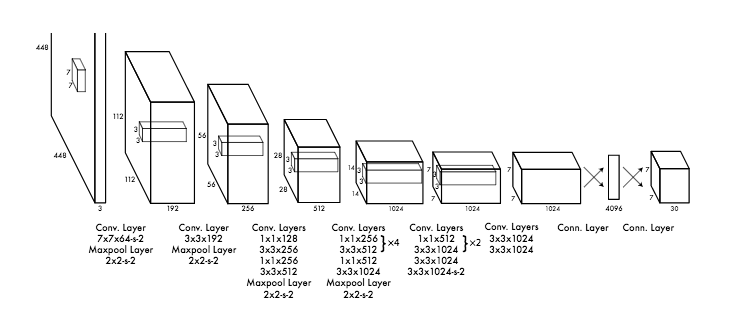

In [4]:
# Input image : 448 x 448 x 3

# First layer
# Conv          : 7 x 7, 64 filters, stride is 2 : output size  = 448/2 x 448/2 x (3x64) = 224 x 224 x 192
# Maxpool layer : 2 x 2,             stride is 2 :  output size = 228/2 x 228/2 x 192    = 112 x 112 x 192

https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO

# Model

In [5]:
import torch
import torch.nn as nn

In [6]:
# 5 x 5 kernel need padding of 2

# padding  padding
#   |    ___|
#  _|_ _|_ ___ ___ ___
# | 1 | 2 | 3 | 4 | 5 | padding
# |___|___|___|___|___|
# | 2 |kernel (5 x 5) | padding
# |___|___|___|___|__ |_ ___ ___ ___ ___
# | 3 |   |0,0|0,1|   |   |   |   |   |   |
# |___|___|___|___|___|___|___|___|___|___|.......
# | 4 |   |1,0|   |   |   |   |   |   |   |
# |___|___|___|___|___|___|___|___|___|___| Image
# | 5 |   |   |   |   |   |   |   |   |   |
# |___|___|___|___|___|___|___|___|___|___|.......
#           .                           .
#           .        Image              .
#           .                           .

In [7]:
architecture_config = [
    (7, 64, 2, 3), # kernel size, number of filters, stride, padding (for 7x7 kernel need padding of 3)
    "M", # Maxpool
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    # [
    #   (kernel size, number of filters, stride, padding),
    #   (kernel size, number of filters, stride, padding),
    #   number of repeats (4)
    # ]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

i.e. each activation is shifted by its own shift parameter (beta). So yes, the batch normalization eliminates the need for a bias vector. Just a side note: in Pytorch the BN's betas are all initialized to zero by default, whereas the biases in linear and convolutional layers are initialized to random values.

In [8]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1) # 0.1 is the slop

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs) # fcs : fully connected layers

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, out_channels=x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1] # update in channels to out channels of layer before

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            out_channels=conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1], # in channels is output of conv1
                            out_channels=conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1] # update in channels to out channels of layer before (conv2 out channels)

        return nn.Sequential(*layers) # (*) for unpack the list and use elements as args
                                      # example for (*)
                                      # def print_abc(a, b, c):
                                      #   print(a, b, c)
                                      #
                                      # a = [1, 2, 3]
                                      # print_abc(*a)
                                      # # output : 1 2 3
        
    def _create_fcs(self, split_size, num_boxes, num_classes): # fcs : fully connected layers
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496), # on original paper 4096
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)), # later this will reshape to S x S x 30 where C + (B*5) = 30
        )

In [9]:
def test(S=7, B=2, C=20):
    model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
    x = torch.randn(2, 3, 448, 448) # 2 examples
    out = model(x)
    print(out)
    print(out.shape)

test() # 1470 later reshape to 7 x 7 x 30

tensor([[ 0.0870,  0.0393,  0.1374,  ..., -0.1829, -0.0624,  0.0423],
        [-0.2144, -0.0691, -0.0627,  ..., -0.2680,  0.0382, -0.2446]],
       grad_fn=<AddmmBackward0>)
torch.Size([2, 1470])


# Loss function

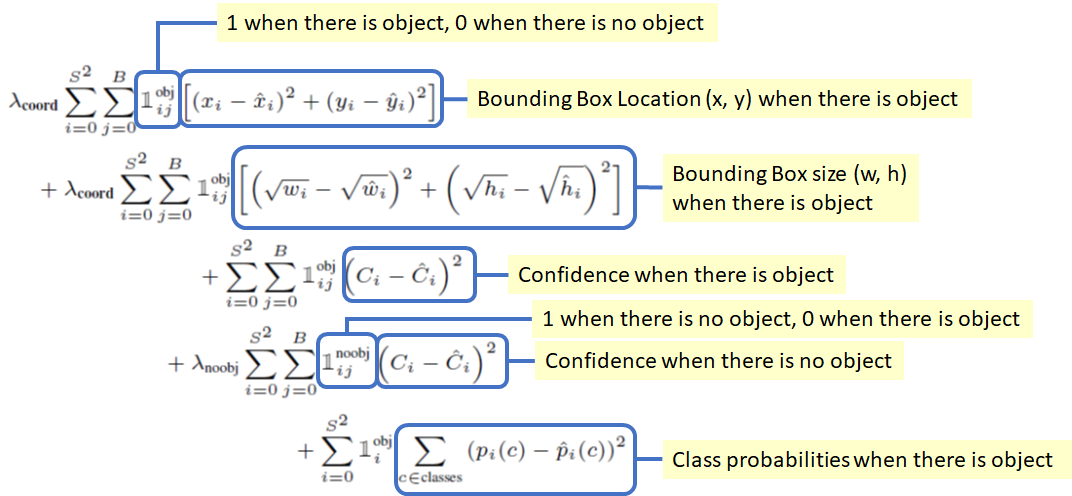

In [10]:
# bounding box, with the highest IOU responsible for error. (I i,j obj = 1)
# To avoid larger errors for large w and h values, take the square root of the w and h values.

In [11]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """
    # ... example
    # lst = np.array([
    #     [1,   2,   3  ],
    #     [11,  22,  33 ],
    #     [111, 222, 333]
    # ])
    # print(lst[..., 0:2])
    # output  = [[  1   2]
    #            [ 11  22]
    #            [111 222]]
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [45]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25]) # iou for box 1
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25]) # iou for box 2
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that  [x, y, w, h]
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        ) # 1e-6 : for avoid derivative of zero
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        # N x S x S x 4 -> N*S*S x 4
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )
        # box_loss is a float value

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        # N x S x S x 1 -> N*S*S
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        # Both boxes should identify there is no object

        # N x S x S x 1 -> N x S*S
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        # N x S x S x 20 -> N*S*S x 20
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss